In [1]:
''' Notebook to demonstrate basic modeling with scikit-learn '''

' Notebook to demonstrate basic modeling with scikit-learn '

In [9]:
import pandas as pd
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
df = pd.read_csv('sample_tweets.csv', encoding='latin-1')

In [96]:
from sklearn.naive_bayes import GaussianNB

subset = df.sample(n=5000)

stop_words = get_stop_words('en')

word_vectorizer = CountVectorizer(ngram_range=(1,3), stop_words=stop_words)
tfidf_transformer = TfidfTransformer(use_idf=True)

word_doc_matrix = word_vectorizer.fit_transform(subset.text)
features = tfidf_transformer.fit_transform(word_doc_matrix)

model = GaussianNB()

# Train the model 
classifier = model.fit(features.toarray(), subset.sentiment)

In [97]:
def predict_sentiment(new_tweets):
    counts = word_vectorizer.transform(new_tweets)
    tfidfs = tfidf_transformer.transform(counts)
    predictions = classifier.predict(tfidfs.toarray())
    return predictions

In [98]:
predict_sentiment(['i hate life', 'i do not want to go to work', 'i love cupcakes'])

array([0, 0, 0])

In [99]:
predict_sentiment(['yay i am so excited to eat cupcakes'])

array([0])

In [100]:
test_tweets = df.sample(n=500)
test_tweets.head(10)

,sentiment,text
278,0,"My son Vincas is sick, so I stay at home Just..."
3799,0,@TomFelton Late nights suckkk! Gym always mak...
2175,0,@icedcoffee they end up back as read only ... ...
7349,4,@stacksnyc LMAO... WHATEVER!! You know what I ...
4096,0,Where's my mail?
5555,4,@seaofbeauty good morning!
9081,4,I think Donnie's hat got enough facetime.. tim...
5515,4,@JustMePammy Not green. Sorry.
9089,4,im fuckin GOOD!!!! MUHAHAHA!! best sleep of my...
6799,4,@rachbarnhart I have plenty of opinions that I...


In [101]:
test_predictions = predict_sentiment(test_tweets.text)

In [102]:
test_predictions[:10]

array([4, 0, 0, 0, 0, 4, 0, 4, 0, 0])

In [103]:
from sklearn.metrics import accuracy_score

accuracy_score(test_tweets.sentiment, test_predictions)

0.80800000000000005

In [104]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(test_tweets.sentiment, test_predictions)

In [105]:
confusion_mat

array([[220,  31],
       [ 65, 184]])

In [106]:
# True positives (they were happy, we predicted happy)
TP = confusion_mat[1][1]

# True negatives (they were sad, we predicted sad)
TN = confusion_mat[0][0]

# False positives (they were sad, we predicted happy)
FP = confusion_mat[0][1]

# False negatives (they were happy, we predicted sad)
FN = confusion_mat[1][0]

print('True positives:', TP)
print('True negatives:', TN)
print('False positives:', FP)
print('False negatives:', FN)

True positives: 184
True negatives: 220
False positives: 31
False negatives: 65


In [107]:
# True positive rate = how often are we correct when they're happy?
TP_rate = TP / float(TP + FN)

# False positive rate = how often are we getting it wrong when they're sad?
FP_rate = FP / float(TN + FP)

TP_rate, FP_rate

(0.73895582329317266, 0.12350597609561753)

In [108]:
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

fp_rate, tp_rate, _ = roc_curve(test_tweets.sentiment == 4, test_predictions == 4)

In [109]:
fp_rate, tp_rate

(array([ 0.        ,  0.12350598,  1.        ]),
 array([ 0.        ,  0.73895582,  1.        ]))

In [110]:
plt.figure();

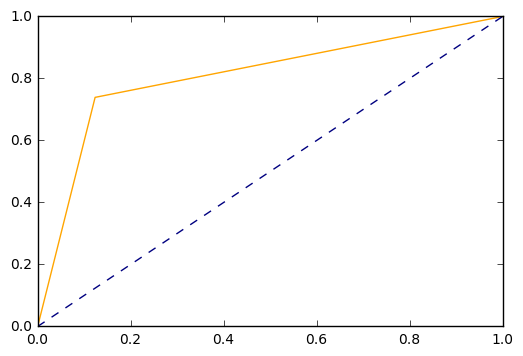

In [111]:
plt.plot(fp_rate, tp_rate, color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

In [112]:
from sklearn.metrics import roc_auc_score

In [113]:
roc_auc_score(test_tweets.sentiment == 4, test_predictions == 4)

0.80772492359877746

In [117]:
tweets = df.text
target = df.sentiment

In [123]:
from sklearn.model_selection import KFold

# List of indices needed to split the actual data
folds = KFold(n_splits=5).split(tweets)

# For each fold, we're going to split our data
# into a training set (on which we train the model),
# and a test set (on which we test the model by
# making predictions)
def split_data(train_indices, test_indices):
    train_tweets = tweets[train_indices]
    train_target = target[train_indices]
    test_tweets = tweets[test_indices]
    test_target = target[test_indices]
    return train_tweets, train_target, test_tweets, test_target

folds = list(folds)
train_indices, test_indices = folds[0]
train_tweets, train_target, test_tweets, test_target = split_data(train_indices, test_indices)

In [125]:
train_tweets.head(), train_target.head()

(2000    Morning twitterati...... Large coffee and a ba...
 2001    hitting the gym! afterwards looking forward to...
 2002                      doesnt  want to go to work lol 
 2003    @SherriGarrity Sorry I missed responding yeste...
 2004                 i wanna come with them to bohol!!!! 
 Name: text, dtype: object, 2000    0
 2001    0
 2002    0
 2003    0
 2004    0
 Name: sentiment, dtype: int64)

In [142]:
def predict_sentiment(classifier, word_vectorizer, tfidf_transformer, new_tweets):
    counts = word_vectorizer.transform(new_tweets)
    tfidfs = tfidf_transformer.transform(counts)
    predictions = classifier.predict(tfidfs.toarray())
    return predictions

def train_and_test(model,
                   train_tweets, train_target, test_tweets, test_target):
    # Learn features from our training data
    word_vectorizer = CountVectorizer(ngram_range=(2,2),
                                      max_features=10000,
                                      stop_words=stop_words)
    tfidf_transformer = TfidfTransformer(use_idf=True)
    word_doc_matrix = word_vectorizer.fit_transform(train_tweets)
    features = tfidf_transformer.fit_transform(word_doc_matrix)
    
    # Train model and build classifier
    classifier = model().fit(features.toarray(), train_target)
    
    # Make predictions
    predictions = predict_sentiment(classifier,
                                    word_vectorizer,
                                    tfidf_transformer,
                                    test_tweets)
    
    # Return score information
    scores = {
        'accuracy': accuracy_score(predictions, test_target),
        'auc': roc_auc_score(predictions == 4, test_target == 4)
    }
    return scores, predictions

In [143]:
train_indices, test_indices = folds[0]
train_tweets, train_target, test_tweets, test_target = split_data(train_indices,
                                                                  test_indices)

In [144]:
scores, predictions = train_and_test(GaussianNB, 
                                     train_tweets, 
                                     train_target, 
                                     test_tweets, 
                                     test_target)

In [145]:
scores

{'accuracy': 0.89849999999999997, 'auc': 0.5}